In [1]:
# Things to do:

    # Regex out a clean seriesname at some point

In [2]:
#Necessary packages
import pandas as pd
import requests
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import calendar
import math

from matplotlib import rc
    #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})

In [3]:
# The location


url = 'https://www.abs.gov.au/statistics/labour/employment-and-unemployment/labour-force-australia/mar-2024/6202001.xlsx'

In [4]:
# Get the file
resp = requests.get(url)

In [5]:
# Open a new file to save down as
output = open('6202001.xlsx', 'wb')
output.write(resp.content)
output.close()

In [6]:
dataSetLF = pd.read_excel('6202001.xlsx', 'Data1');

##ABS Labour Force

In [7]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d-%m-%Y")
current_date_and_time = now.strftime("%H:%M:%S %d-%m-%Y")
#print("Graphs updated at " + current_time + " on " + current_date)
print("Graphs and data updated at " + current_time + " on " + current_date)


Graphs and data updated at 21:19:41 on 04-05-2024


In [8]:
metaDataDict = {}

for col in dataSetLF:
    #print('A new column')
    #print(col)
    unit = dataSetLF[col][0]
    #print(seasAdjust)
    seasAdjust = dataSetLF[col][1]
    #print(seasAdjust)
    dataType = dataSetLF[col][2]
    #print(dataType)
    frequency = dataSetLF[col][3]
    #print(frequency)
    collectionMonth = dataSetLF[col][4]
    #print(collectionMonth)
    startDate = dataSetLF[col][5]
    #print(startDate)
    endDate = dataSetLF[col][6]
    #print(endDate)
    numberObs = dataSetLF[col][7]
    #print(numberObs)
    seriesNumber = dataSetLF[col][8]
    #print(seriesNumber)
    
    dictName = seriesNumber
    
    seriesDict = {
    "seriesName" : col,
    "unit" : unit,
    "seriesType" : seasAdjust,
    "dataType" : dataType,
    "startDate" : startDate,
    "endDate" : endDate,
    "seriesNumber" : seriesNumber
    }
    
    #print(dictName)
    
    metaDataDict[seriesNumber] = seriesDict
    

In [9]:
# Name the columns after the ABS series ID and fix the date column

dataSetLF.columns = dataSetLF.iloc[8];

dataSetLF = dataSetLF[9:]

dataSetLF.columns = dataSetLF.columns.str.replace('Series ID', 'Date') #Rename the date column

#dataSetLF.head(10)


In [10]:
def graph_series_abs(seriesCode, data, startDate, endDate, lastPointOption, metaData):
    
    metaData = metaDataDict[seriesCode]
    
    #print(metaData)
    
    seriesName = metaData.get('seriesName')
    #print(seriesName)
    
    #Get the data
    values = data[seriesCode]
    dates = data["Date"]
    

    
    #Filter to the desired date range
    mask = (data.loc[:,'Date'] > startDate) & (data.loc[:,'Date'] < endDate)
    dataToGraph = values.loc[mask]
    datesToGraph = dates.loc[mask]
    
    #Get range for vertical axis
    maxValue = max(dataToGraph)
    minValue = min(dataToGraph)
    difference = maxValue - minValue
    
    vertRangeUpper = math.ceil(maxValue + difference * .1)
    vertRangeLower = math.floor(minValue - difference * .1) 
    
    #print(vertRangeUpper)
    #print(vertRangeLower)
    
    #Only use years as labels on the horiztonal axis
    yearsToGraph = [date for date in datesToGraph if date.month == 1]
    
    #If more than 10 years, cuts the labelling and ticks down to every second year
    if len(yearsToGraph) > 12:
        yearsToGraph = [date for date in datesToGraph if date.month == 1 and (date.year % 2 == 0)]
    
    #Extract year labels
    yearsOnly = [date.year for date in yearsToGraph if date.month == 1 ]
    
    #Just hashed out for a test
    plt.rcParams.update({'font.size': 14})
    font = {'size'   : 14}
    matplotlib.rc('font', **font)
    
    # Create a figure containing a single axes.
    fig, ax = plt.subplots()
    
    fig.set_size_inches(7, 5, forward=True)
    
    # Make the figure
    ax.plot(datesToGraph, dataToGraph, 'b', linewidth= '3')
    
    ax.axhline(y=0.0, color='black', linestyle='-', linewidth= '1')
    
    # Get the last data point for highlighting 
    lastData = dataToGraph.values[-1]
    lastDate = datesToGraph.values[-1]
    
    # X-ticks set as calculated above
    ax.set_xticks(yearsToGraph)
    
    # All graphs named by series plus per cent in subtitle (could be better)
    units = metaData.get('unit')
    seriesType = metaData.get('seriesType')
    ax.set_title(seriesName + "\n" + seriesType + ", " + units)
    
    # X-axis labels are whole years only 
    ax.set_xticklabels(yearsOnly)
    
    ax.tick_params(labelleft=True, labelright=True)
                     #bottom=True, top=False, left=False, right=False)
    
    ax.set_ylim([vertRangeLower, vertRangeUpper])
    
    #Make the chart start show whole years only
    last_day_of_last_year = endDate.replace(month=12, day=31)    
    first_day_of_first_year = startDate.replace(month=1, day=1)
    ax.set_xlim([first_day_of_first_year, last_day_of_last_year])
    
    
    
    #Fonts
    
    #horizAxisStart = ax.get_xlim()[0]
    #print(horizAxisStart)
    #horizAxisEnd = ax.get_xlim()[1]
    #print(horizAxisEnd)
    #horizAxisLength = horizAxisEnd - horizAxisStart
    #print()
    
    #vertAxisStart = ax.get_ylim()[0]
    #print(vertAxisStart)
    #vertAxisEnd = ax.get_ylim()[1]
    #print(vertAxisEnd)
    #vertAxisLength = vertAxisEnd - vertAxisStart
    
    
    if lastPointOption:
        
        ax.plot(lastDate, lastData, 'r.', markersize= '10')
        
        lastDateMonth = calendar.month_name[lastDate.month] 
        
        unitForText = units
        if unitForText == "000":
            unitForText = " thousand"
        else:
            unitForText = " percent"
    
        #Add some metadata for the last datapoint
        textstr = "Lastest data point is " + str(round(lastData,2)) \
        + unitForText + " for \n" + calendar.month_name[lastDate.month] + " " + str(lastDate.year)
        props = dict(boxstyle='round', facecolor='none', alpha=0.5, edgecolor='none')
        ax.text(.01,.90, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', bbox=props, color = 'red')

    filename = seriesName + str(startDate) + str(endDate) + ".jpg"
    #print(filename)
    plt.savefig(filename)

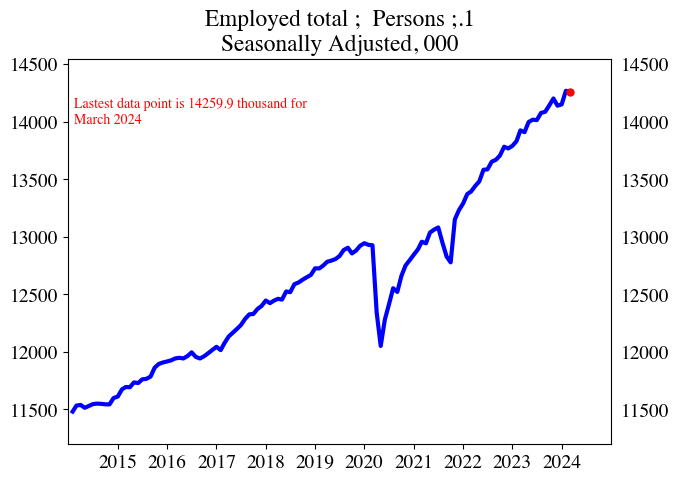

In [11]:
startDateExample = datetime(2014, 1, 1)
endDateExample = datetime(2024, 12, 31)
seriesToGraph = 'A84423043C'

graph_series_abs(seriesToGraph, dataSetLF, startDateExample, endDateExample,1, metaDataDict)

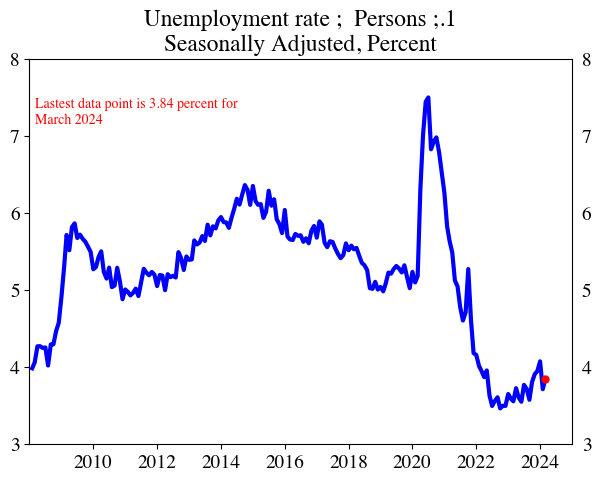

In [12]:
startDateExample = datetime(2008, 1, 1)
endDateExample = datetime(2024, 12, 31)
seriesToGraph = 'A84423050A'

graph_series_abs(seriesToGraph, dataSetLF, startDateExample, endDateExample,1, metaDataDict)

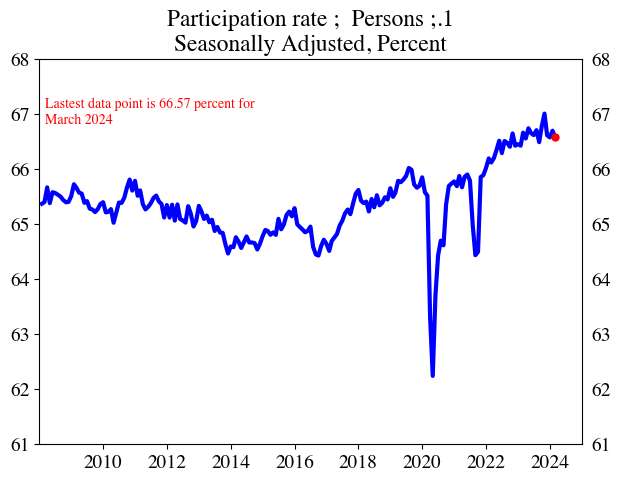

In [13]:
startDateExample = datetime(2008, 1, 1)
endDateExample = datetime(2024, 12, 31)
seriesToGraph = 'A84423051C'

graph_series_abs(seriesToGraph, dataSetLF, startDateExample, endDateExample,1, metaDataDict)

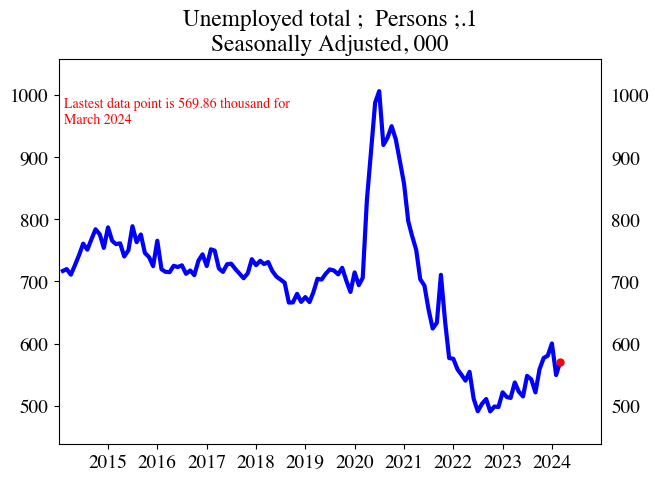

In [14]:
startDateExample = datetime(2014, 1, 1)
endDateExample = datetime(2024, 12, 31)
seriesToGraph = 'A84423046K'

graph_series_abs(seriesToGraph, dataSetLF, startDateExample, endDateExample,1, metaDataDict)



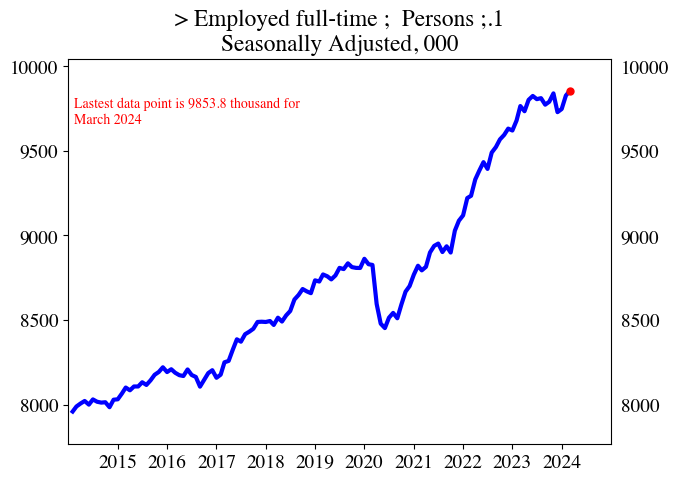

In [15]:
startDateExample = datetime(2014, 1, 1)
endDateExample = datetime(2024, 12, 31)
seriesToGraph = 'A84423041X'

graph_series_abs(seriesToGraph, dataSetLF, startDateExample, endDateExample,1, metaDataDict)


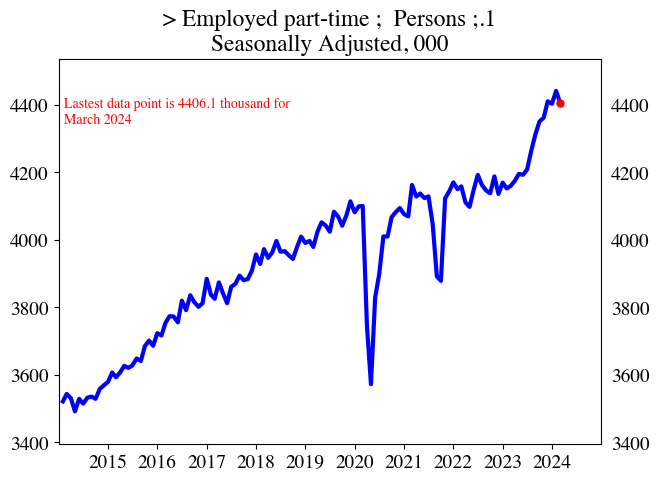

In [16]:
startDateExample = datetime(2014, 1, 1)
endDateExample = datetime(2024, 12, 31)
seriesToGraph = 'A84423042A'

graph_series_abs(seriesToGraph, dataSetLF, startDateExample, endDateExample,1, metaDataDict)


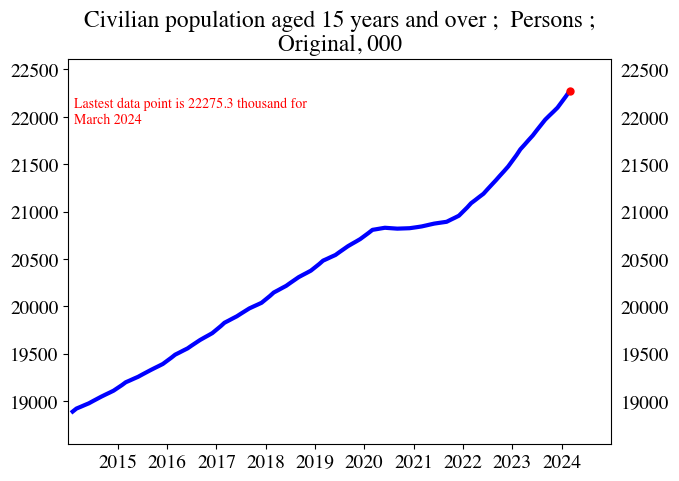

In [17]:
startDateExample = datetime(2014, 1, 1)
endDateExample = datetime(2024, 12, 31)
seriesToGraph = 'A84423091W'

graph_series_abs(seriesToGraph, dataSetLF, startDateExample, endDateExample,1, metaDataDict)